In [1]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
import math
# from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
# from mappings import *
from train_functions import *
from random import shuffle

2.0.1
2.0.1


In [2]:
def print_obj_API(obj):
    attributes = [attr for attr in dir(obj) if not attr.startswith('__')]

    # Differentiating between methods and attributes
    methods = [attr for attr in attributes if callable(getattr(obj, attr)) and not attr.startswith('_')]
    attributes = [attr for attr in attributes if not callable(getattr(obj, attr)) and not attr.startswith('_')]
    
    print(f"{type(obj).__name__} Attributes:", attributes)
    print("\n")
    print(f"{type(obj).__name__} Methods:", methods)

In [3]:
#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 

[13:00:17] WARNING: no name column found on line 0
[13:00:17] WARNING: no name column found on line 1
[13:00:17] WARNING: no name column found on line 2
[13:00:17] WARNING: no name column found on line 3
[13:00:17] WARNING: no name column found on line 4
[13:00:17] WARNING: no name column found on line 5
[13:00:17] WARNING: no name column found on line 6
[13:00:17] WARNING: no name column found on line 7
[13:00:17] WARNING: no name column found on line 8
[13:00:17] WARNING: no name column found on line 9
[13:00:17] WARNING: no name column found on line 10
[13:00:17] WARNING: no name column found on line 11
[13:00:17] WARNING: no name column found on line 12
[13:00:17] WARNING: no name column found on line 13
[13:00:17] WARNING: no name column found on line 14
[13:00:17] WARNING: no name column found on line 15
[13:00:17] WARNING: no name column found on line 16
[13:00:17] WARNING: no name column found on line 17
[13:00:17] WARNING: no name column found on line 18
[13:00:17] WARNING: no

In [4]:
def get_random_batch(data = train_guac_mols, bs=32):
    shuffle(train_guac_mols)
    return rdkit2pyg(train_guac_mols[:bs])

In [5]:
#! --- SET UP EXPERIMENT ---
LR = 1e-5
epoch, max_epoch = 1, 150
bs = 32 # 512
wd = 5e-4

train_data = get_random_batch(bs=bs)
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()

for m in [rnn, output]:
    m.apply(weight_init)
    m.ad_hoc_init()

optimizer = torch.optim.RMSprop(list(rnn.parameters()) + list(output.parameters()), lr=LR, weight_decay=wd, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

# MEMORIZATION

In [6]:
# obs = train_guac_mols[5]
# print(Chem.MolToSmiles(obs))
# train_data = rdkit2pyg([obs])

# train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
# max_epoch = 10000
# params = list(rnn.parameters()) + list(output.parameters())
# optimizer = torch.optim.RMSprop(params, lr=1e-5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
# memorize_batch_single_opt(max_epoch, rnn, output, train_dataset_loader, optimizer, node_weights, edge_weights, scheduler)

# LSUV

In [7]:
# # A hook executes a f that MUST takes 3 args: a module, an input and an output
# def _lsuv_stats(hook, module, inpt, outpt):
#     ''' For each layer stores mean/std'''
#     acts = to_cpu(outpt)
#     hook.mean = acts.mean()
#     hook.std = acts.std()

# def lsuv_init(activation_module, module_input_to_activation, xb):
#     '''
#     activation_module: module that contains the act func of the layer
#     module_input_to_activation: module that contain the weights used in activation_module
#     xb: batch    
#     '''    
#     h = Hook(activation_module, _lsuv_stats) # registers a forw_hook which executes _lsuv_stats
#     with torch.no_grad():
#         while(model(xb)) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
#             # modify weights untill activated layer has m=0, std=1
#             module_input_to_activation.bias -= h.mean
#             module_input_to_activation.weight.data /= h.std
#     h.remove()    

# Activations analysis

In [10]:
for idx, (name, module) in enumerate(rnn.named_children()): print(name, module, module)

embedding Linear(in_features=447, out_features=1024, bias=True) Linear(in_features=447, out_features=1024, bias=True)
embeddingLRelu LeakyReLU(negative_slope=0.01) LeakyReLU(negative_slope=0.01)
rnn GRU(1024, 1024, num_layers=4, batch_first=True) GRU(1024, 1024, num_layers=4, batch_first=True)
output1 Linear(in_features=1024, out_features=768, bias=True) Linear(in_features=1024, out_features=768, bias=True)
outputLRelu LeakyReLU(negative_slope=0.01) LeakyReLU(negative_slope=0.01)
output2 Linear(in_features=768, out_features=768, bias=True) Linear(in_features=768, out_features=768, bias=True)
node_mlp1 Linear(in_features=1024, out_features=768, bias=True) Linear(in_features=1024, out_features=768, bias=True)
nodeNorm LayerNorm((768,), eps=1e-05, elementwise_affine=True) LayerNorm((768,), eps=1e-05, elementwise_affine=True)
nodeLRelu LeakyReLU(negative_slope=0.01) LeakyReLU(negative_slope=0.01)
node_mlp2 Linear(in_features=768, out_features=12, bias=True) Linear(in_features=768, out_feat

In [11]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_output_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    elif isinstance(module, nn.LeakyReLU):
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []

In [12]:
layer_means_rnn.keys()

dict_keys(['embeddingLRelu', 'rnn_output_2', 'rnn_hidden_2', 'outputLRelu', 'nodeLRelu'])

In [13]:
def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    elif isinstance(module, nn.LeakyReLU):
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

In [14]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [15]:
epoch = 0
while epoch < max_epoch:
    loss, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                            data_loader_=train_dataset_loader,
                                            optimizer=optimizer,
                                            node_weights=node_weights, edge_weights=edge_weights,
                                            scheduler = scheduler)
    print(f"Epoch {epoch}, loss_edg: {loss_edg}, loss_nodes: {loss_nodes}")
    epoch +=1

Epoch 0, loss_edg: 0.4813137352466583, loss_nodes: 0.1662920117378235
Epoch 1, loss_edg: 0.48045068979263306, loss_nodes: 0.16622427105903625
Epoch 2, loss_edg: 0.4789620637893677, loss_nodes: 0.1661081314086914
Epoch 3, loss_edg: 0.476842999458313, loss_nodes: 0.16594381630420685
Epoch 4, loss_edg: 0.4739822447299957, loss_nodes: 0.16572359204292297
Epoch 5, loss_edg: 0.47021767497062683, loss_nodes: 0.1654357761144638
Epoch 6, loss_edg: 0.46535611152648926, loss_nodes: 0.16506685316562653
Epoch 7, loss_edg: 0.4591856002807617, loss_nodes: 0.1646033078432083
Epoch 8, loss_edg: 0.45149409770965576, loss_nodes: 0.16403265297412872
Epoch 9, loss_edg: 0.442095547914505, loss_nodes: 0.16334503889083862
Epoch 10, loss_edg: 0.43074822425842285, loss_nodes: 0.16253352165222168
Epoch 11, loss_edg: 0.41722917556762695, loss_nodes: 0.16159534454345703
Epoch 12, loss_edg: 0.40128186345100403, loss_nodes: 0.1605319231748581
Epoch 13, loss_edg: 0.3825990855693817, loss_nodes: 0.15934941172599792
Ep

## Activations

Text(0.5, 1.0, 'MEANS')

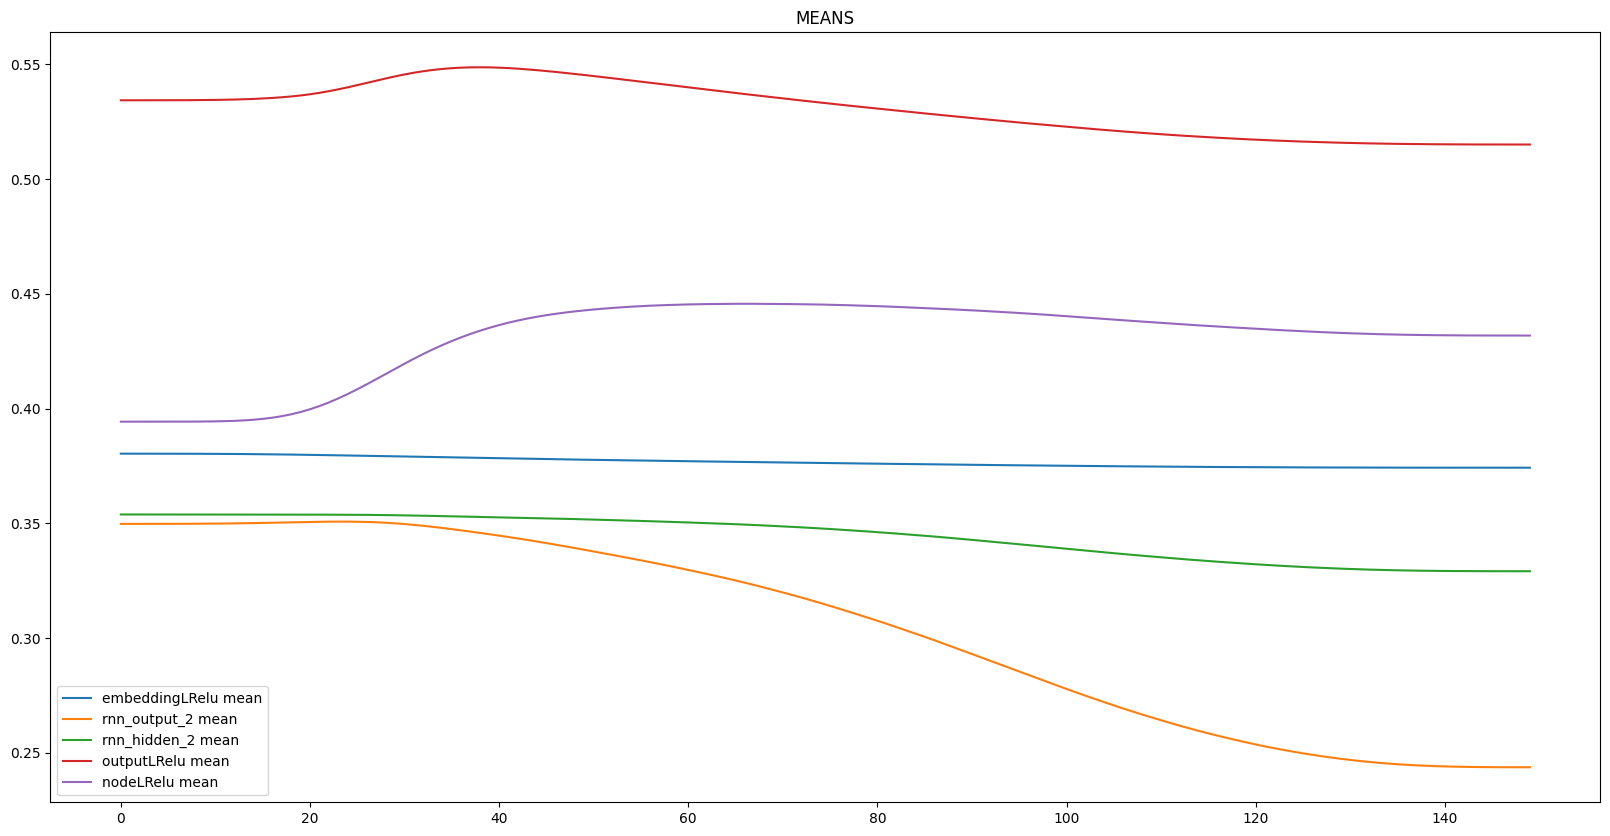

In [20]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("MEANS")

Text(0.5, 1.0, 'STDS')

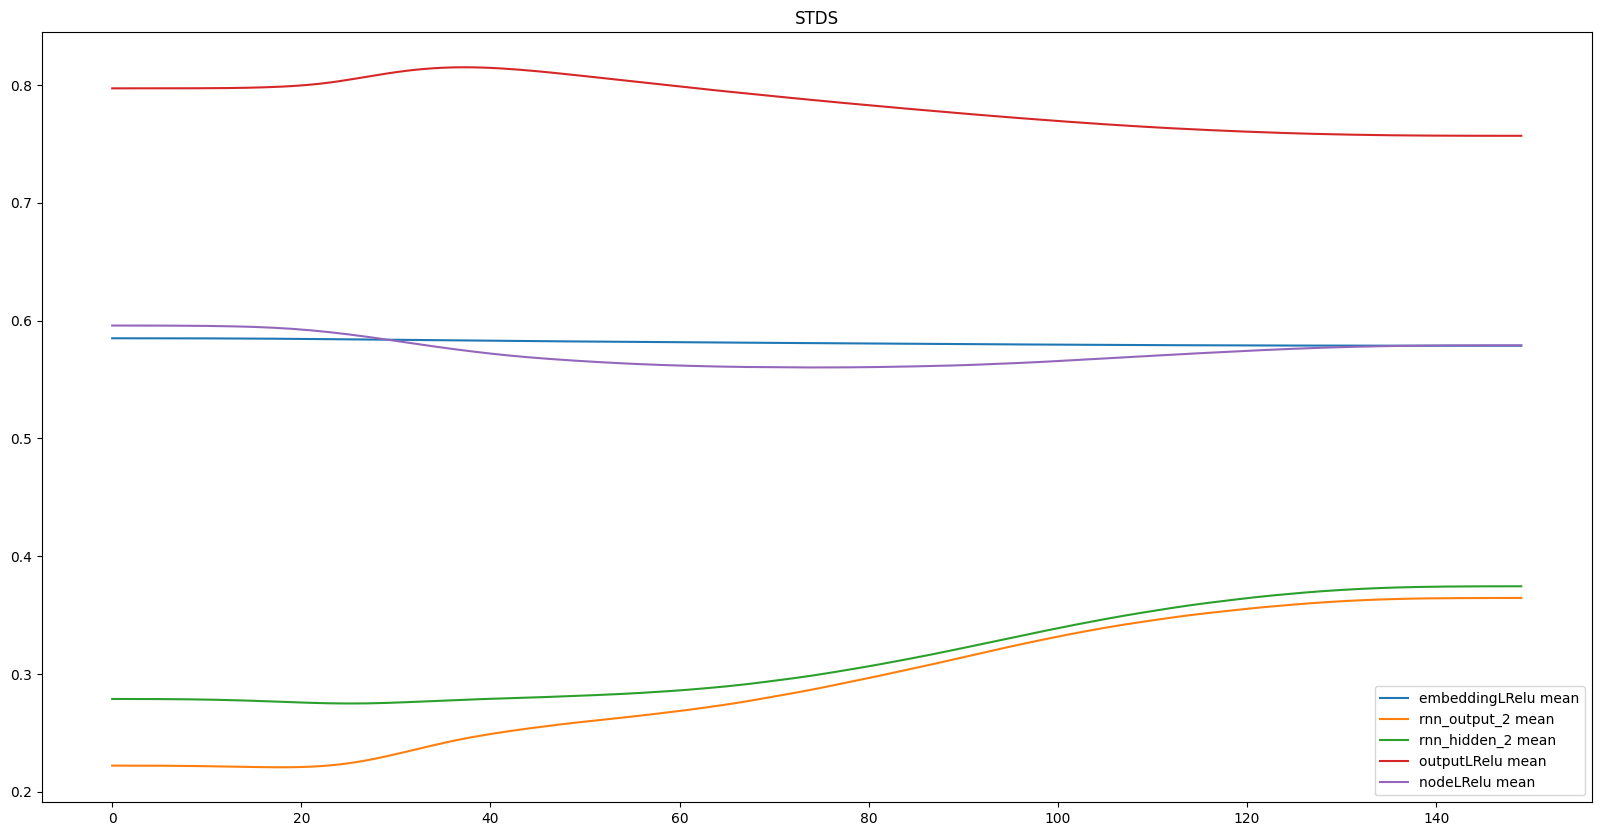

In [21]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("STDS")

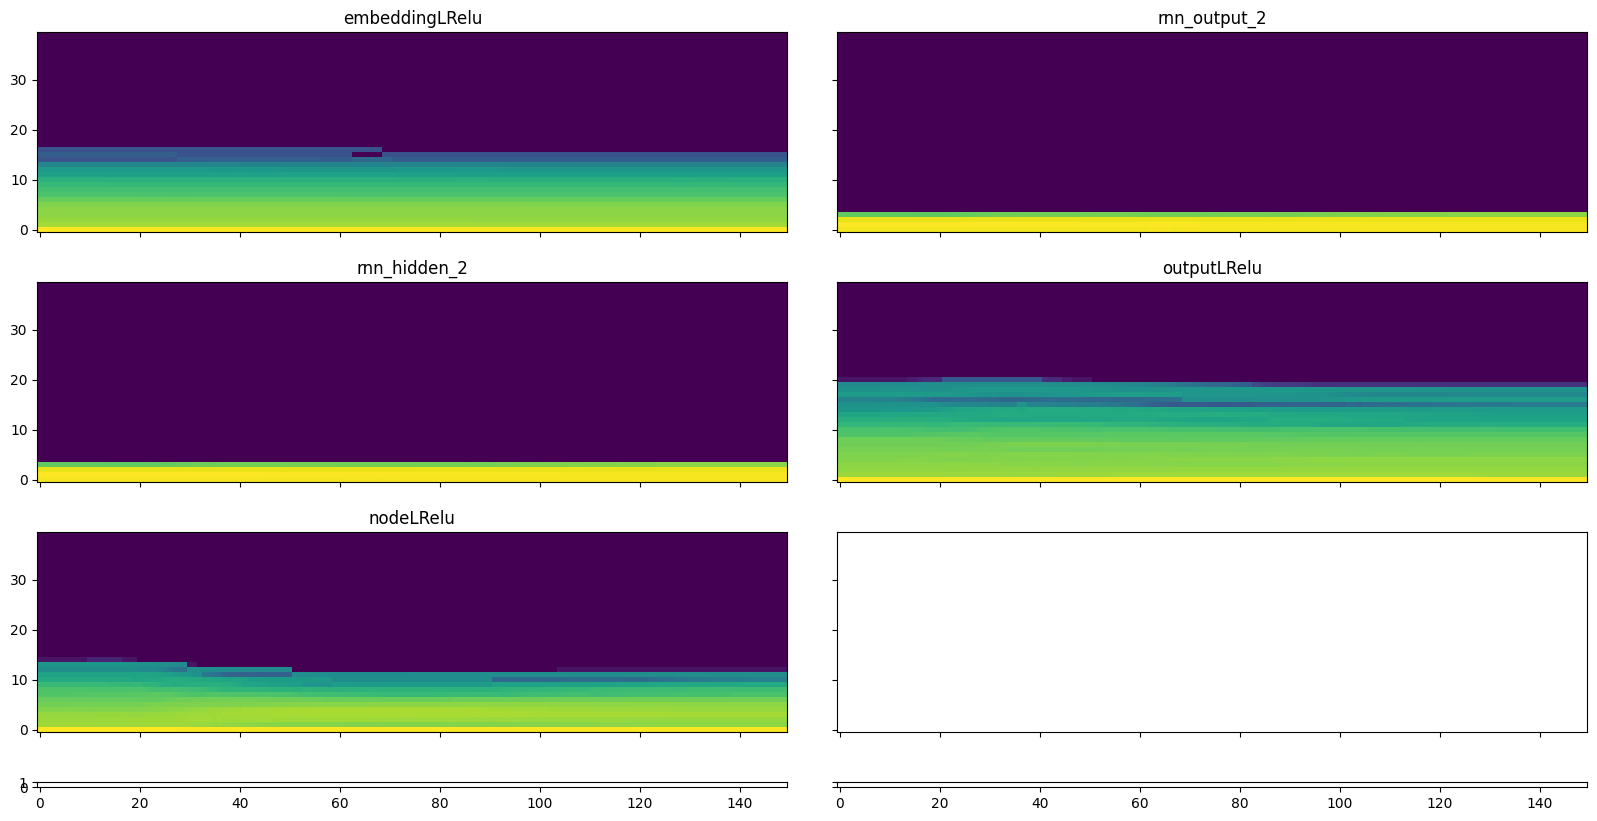

In [22]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_rnn.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_rnn[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

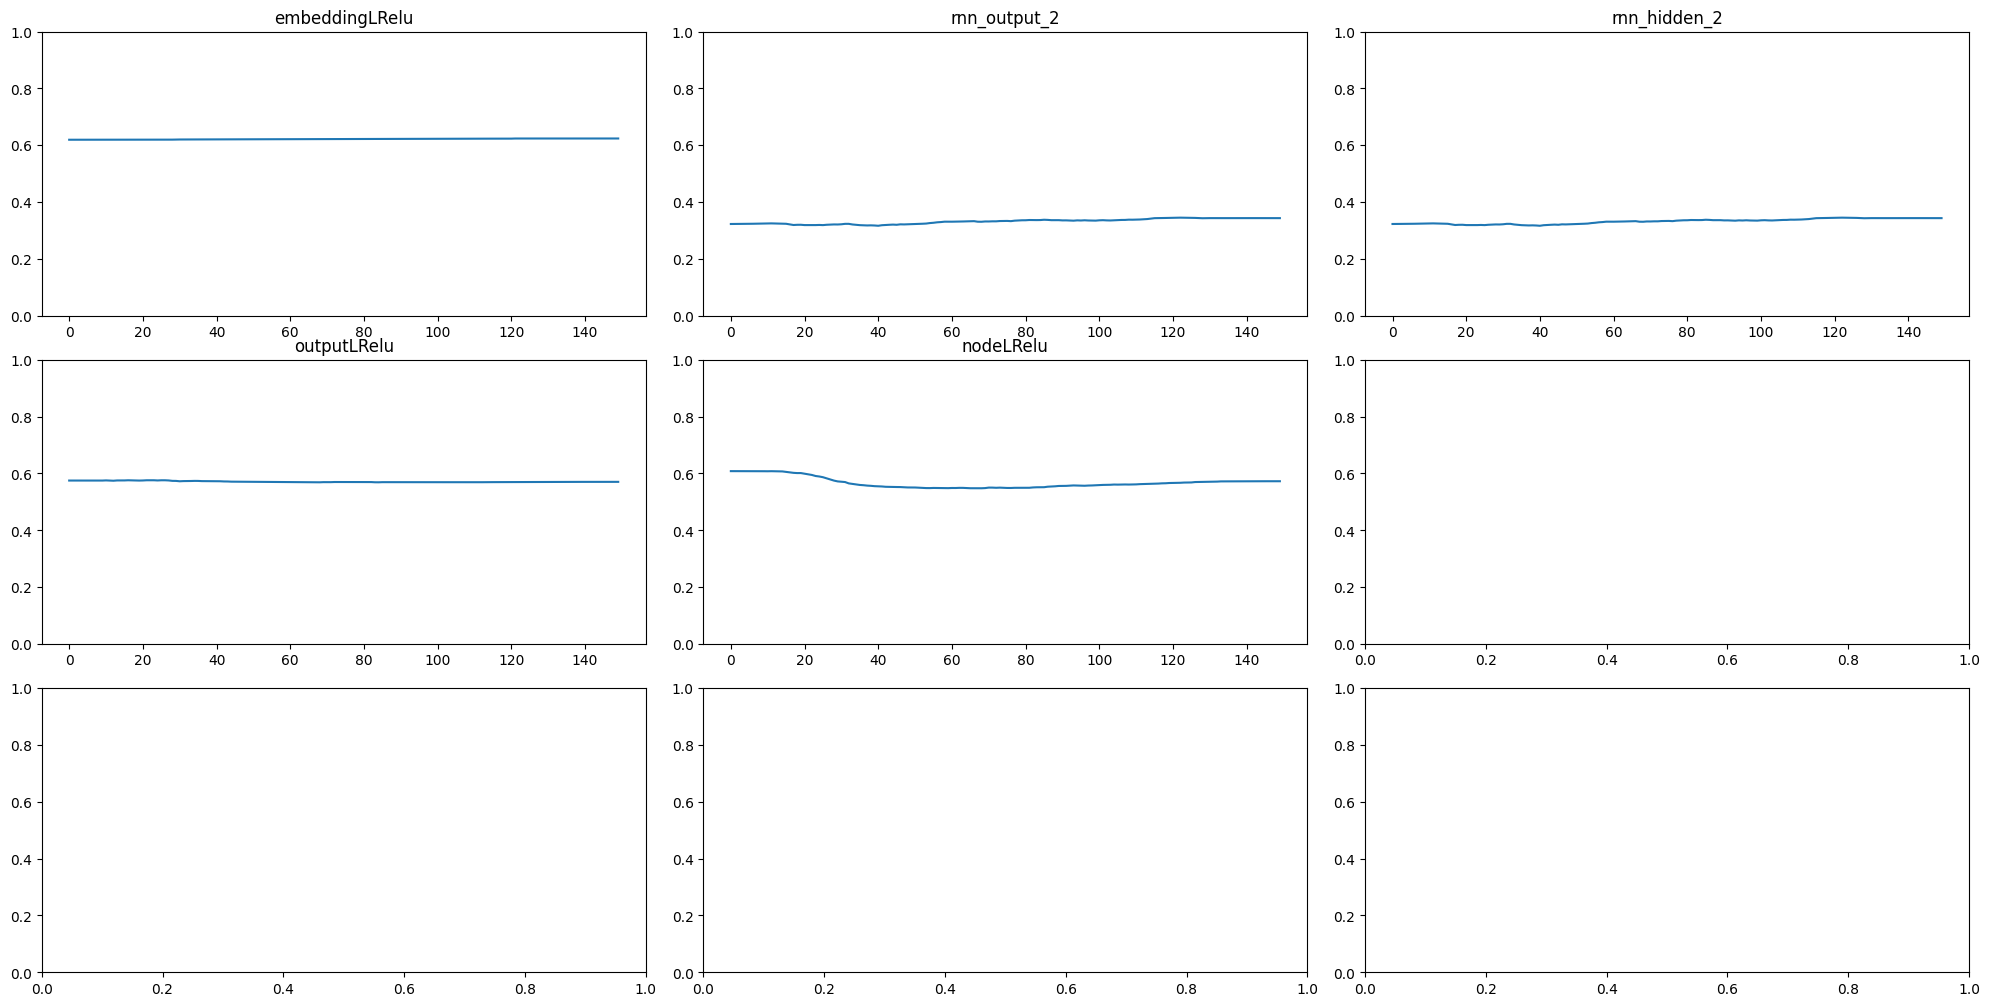

In [23]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(3,3, figsize=(20, 10))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_rnn.keys())):
    h = layer_hists_rnn[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)

# GRADIENTS

In [19]:
#! --- SET UP EXPERIMENT ---
LR = 1e-5
epoch, max_epoch = 1, 150
bs = 32 # 512
wd = 5e-4

train_data = get_random_batch(bs=bs)
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()

for m in [rnn, output]:
    m.apply(weight_init)
    m.ad_hoc_init()

optimizer = torch.optim.RMSprop(list(rnn.parameters()) + list(output.parameters()), lr=LR, weight_decay=wd, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

In [20]:
grads_dict = {}
for name, module in rnn.named_modules():
    for pname, p in module.named_parameters():
        if ".weight" in pname:
            grads_dict[pname] = []

@torch.no_grad()
def get_grads():
    for name, module in rnn.named_modules():
        for pname, p in module.named_parameters():
            if ".weight" in pname:
                grads_dict[pname].append(p.grad.data)



In [21]:
epoch = 0
update = []
while epoch < max_epoch:
    rnn.train()
    output.train()
    loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
    for batch_idx, data in enumerate(train_dataset_loader):
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        get_grads()
        if scheduler != None: 
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr'][0]
        
        with torch.no_grad():
            update.append([(current_lr* p.grad.std()/p.data.std()).log10().item() for p in rnn.parameters()])
        
        optimizer.step()        
        if scheduler != None: scheduler.step()
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    epoch +=1


Epoch 0,  tensor(0.8159, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5341, device='cuda:0')  lossnodes  tensor(0.2817, device='cuda:0')
Epoch 1,  tensor(0.8148, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5333, device='cuda:0')  lossnodes  tensor(0.2815, device='cuda:0')
Epoch 2,  tensor(0.8129, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5318, device='cuda:0')  lossnodes  tensor(0.2811, device='cuda:0')
Epoch 3,  tensor(0.8102, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5296, device='cuda:0')  lossnodes  tensor(0.2805, device='cuda:0')
Epoch 4,  tensor(0.8065, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5267, device='cuda:0')  lossnodes  tensor(0.2798, device='cuda:0')
Epoch 5,  tensor(0.8018, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.5229, device='cuda:0')  lossnodes  tensor(0.2789, device='cuda:0')
Epoch 6,  tensor(0.7956, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.518

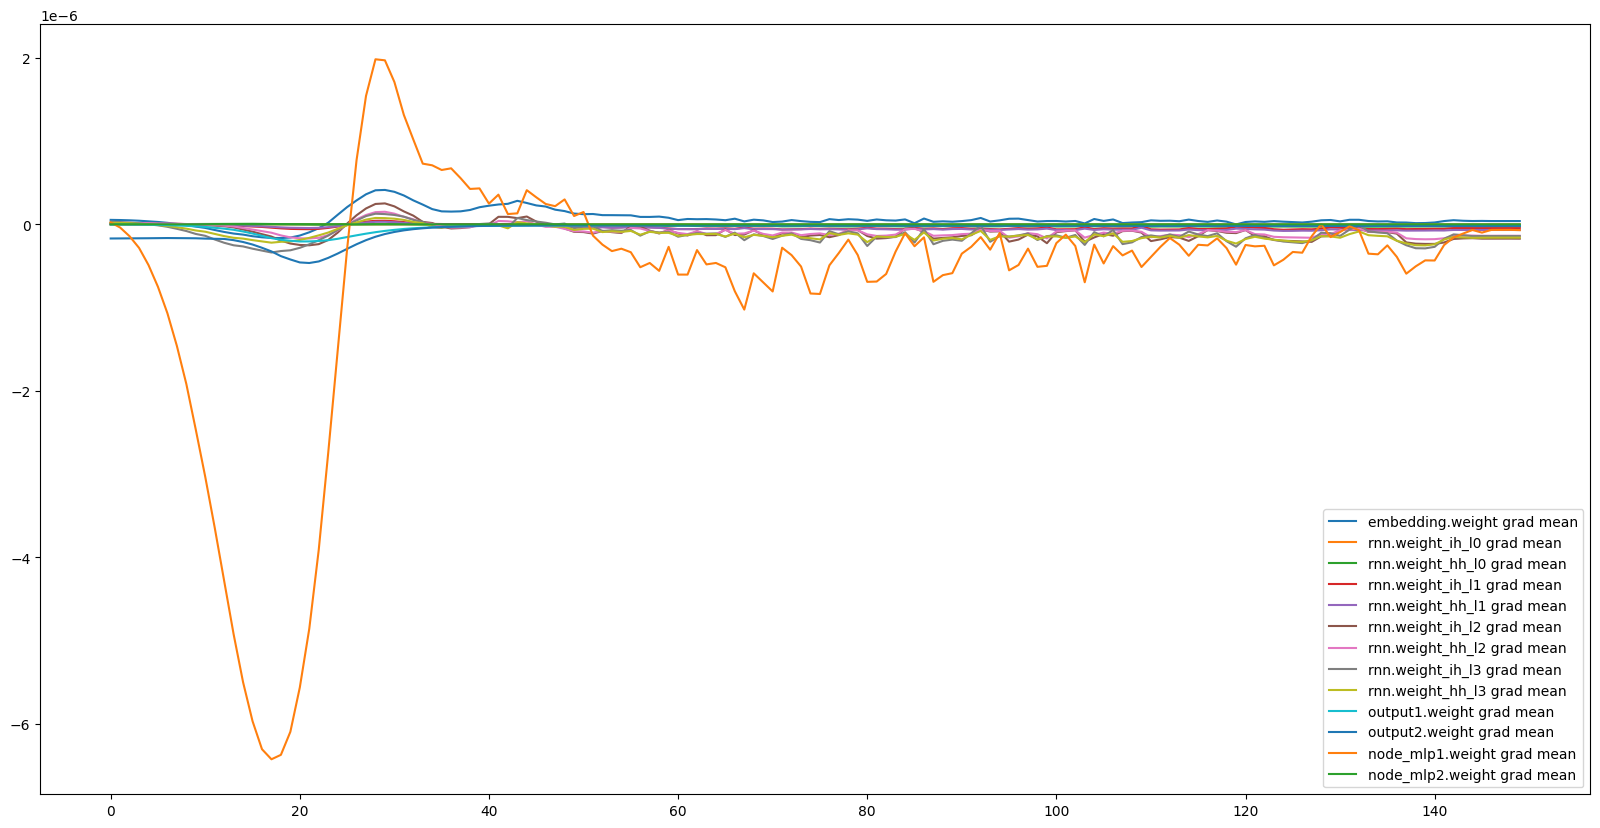

In [22]:
plt.figure(figsize=(20,10))

for k in grads_dict.keys():
    l = grads_dict[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.mean().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')

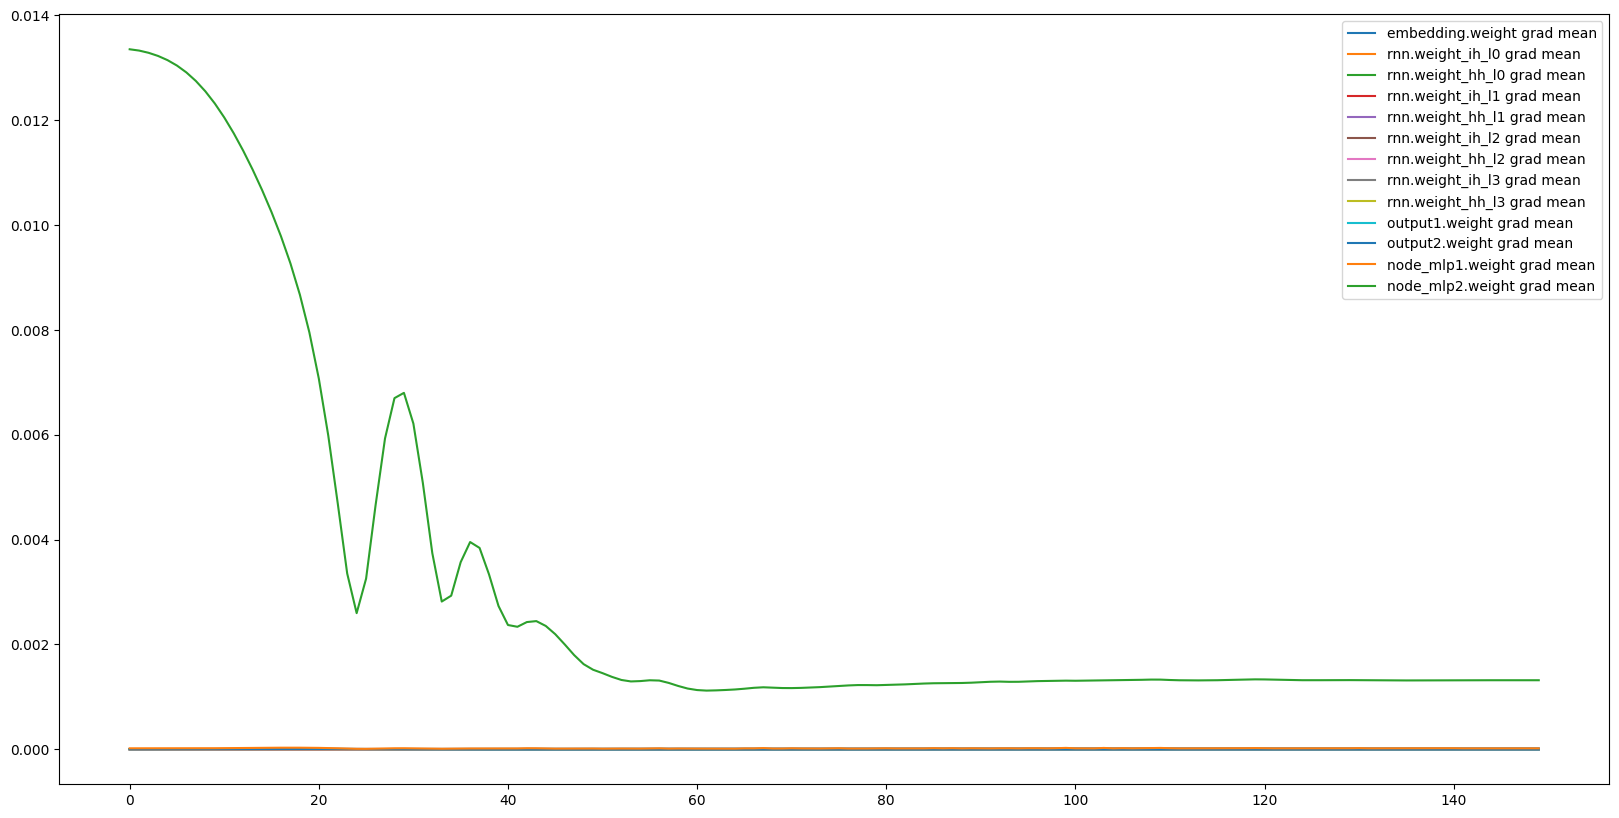

In [23]:
plt.figure(figsize=(20,10))

for k in grads_dict.keys():
    l = grads_dict[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.std().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')

Text(0.5, 1.0, 'weights and Gradients distribution')

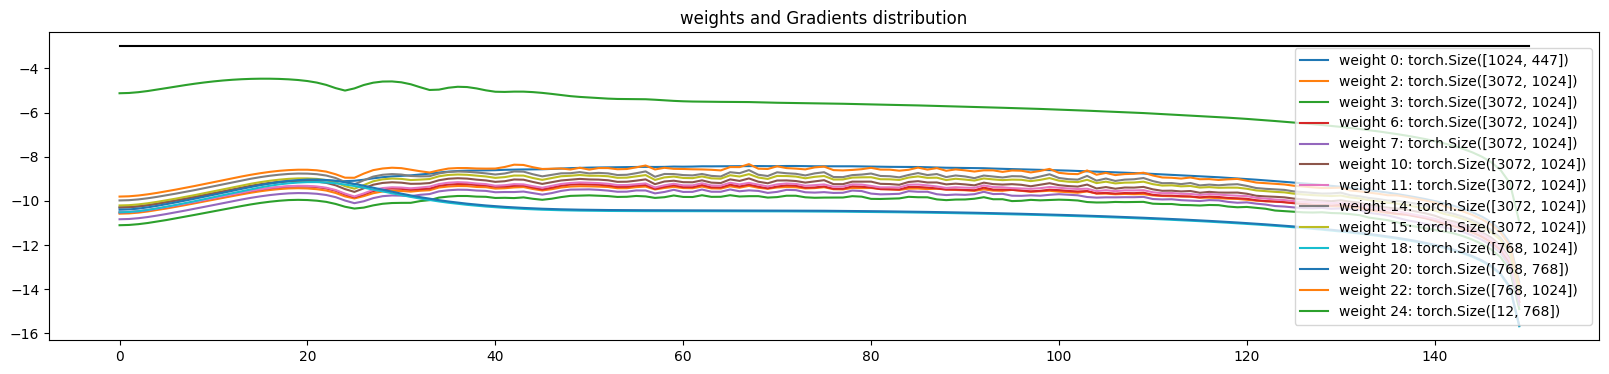

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(rnn.parameters()):
    if p.ndim == 2:
        plt.plot([update[j][i] for j in range(len(update))])
        legends.append(f'weight {i}: {p.shape}')
plt.plot([0, len(update)], [-3, -3], 'k') # guide/target ~ 1e-3
plt.legend(legends)
plt.title('weights and Gradients distribution')

In [ ]:
# so theoretically we are not updating fast enough

# lr finder

In [62]:
shuffle(train_guac_mols)
train_data = rdkit2pyg(train_guac_mols[:32])

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS

rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=1e-6, weight_decay=5e-4, eps=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)

In [63]:
lrs, losses_lr = [], []
min_loss = math.inf
epoch = 0

while True:
    rnn.train()
    output.train()
    loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
    for batch_idx, data in enumerate(train_dataset_loader):
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        losses_lr.append(loss.item())
        if scheduler != None: current_lr = scheduler.get_last_lr()[0]
        else: current_lr = optimizer.param_groups[0]['lr'][0]
        optimizer.step()    
        lrs.append(current_lr)    
        if loss < min_loss: min_loss = loss
        if loss > 3 * min_loss: assert False
        if scheduler != None: scheduler.step()
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    epoch +=1


Epoch 0,  tensor(0.5890, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4412, device='cuda:0')  lossnodes  tensor(0.1478, device='cuda:0')
Epoch 1,  tensor(0.5888, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4410, device='cuda:0')  lossnodes  tensor(0.1478, device='cuda:0')
Epoch 2,  tensor(0.5886, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4409, device='cuda:0')  lossnodes  tensor(0.1478, device='cuda:0')
Epoch 3,  tensor(0.5885, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4407, device='cuda:0')  lossnodes  tensor(0.1477, device='cuda:0')
Epoch 4,  tensor(0.5883, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4406, device='cuda:0')  lossnodes  tensor(0.1477, device='cuda:0')
Epoch 5,  tensor(0.5881, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.4404, device='cuda:0')  lossnodes  tensor(0.1477, device='cuda:0')
Epoch 6,  tensor(0.5880, device='cuda:0', grad_fn=<DivBackward0>) lossedges tensor(0.440

AssertionError: 

Text(0, 0.5, 'Loss')

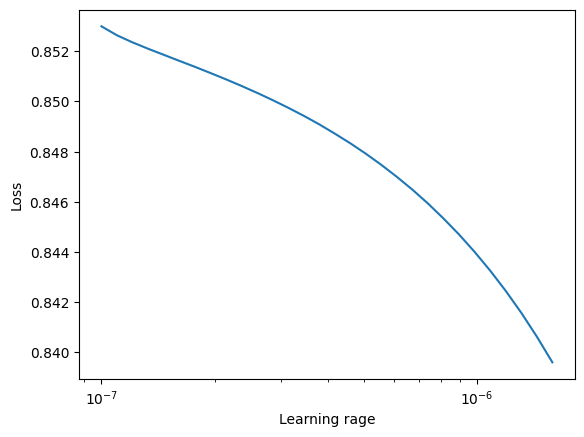

In [61]:
plt.plot(lrs, losses_lr)
plt.xscale('log')
plt.xlabel("Learning rage")
plt.ylabel("Loss")